## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

from itertools import chain
from random import sample 
import scipy

import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, average_precision_score
import math

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
35341,00009327_006.png,Effusion,6,9327,49,F,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00009327_006.png
9169,00002395_019.png,Effusion,19,2395,62,F,AP,2500,2048,0.168,0.168,NaN,/data/images_002/images/00002395_019.png
17338,00004652_008.png,Nodule,8,4652,57,M,AP,2500,2048,0.171,0.171,NaN,/data/images_003/images/00004652_008.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_xray_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_xray_labels = [x for x in all_xray_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_xray_labels), all_xray_labels))
for c_label in all_xray_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(5)
all_xray_labels = set(all_xray_labels)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda x: 'Y' if x['Pneumonia'] == 1.0 else 'N', axis=1)
all_xray_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N


In [5]:
# get rid of the >100 year old cases
all_xray_df = all_xray_df[all_xray_df['Patient Age']<=100]

## Create your training and testing data:

In [6]:
def create_splits(**vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    d=vargs['df']
    train_df, valid_df = skl.train_test_split(d, test_size=0.2, stratify = d['pneumonia_class'])
    t_ratio= len(train_df[train_df['pneumonia_class'] =='Y'])/len(train_df)
    v_ratio= len(valid_df[valid_df['pneumonia_class'] =='Y'])/len(valid_df)
    print(f'Initial split: Training (pneumonia): {100.0*t_ratio :.2f}%. Validation (pneumonia): {100.0*v_ratio :.2f}%')
    
    # Edit training to be 50/50
    t_p_inds = train_df[train_df['pneumonia_class'] == 'Y'].index.tolist()
    t_np_inds = train_df[train_df['pneumonia_class'] == 'N'].index.tolist()

    np_sample = sample(t_np_inds,len(t_p_inds))
    train_df = train_df.loc[t_p_inds + np_sample]
    t_ratio_edit=len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    print(f'New test split (pneumonia): {100.0*t_ratio_edit :.2f}%')
    
    # Edit validation to be real world (Info in EDA was not real-world, will stick with 20%)
    v_p_inds = valid_df[valid_df['pneumonia_class'] == 'Y'].index.tolist()
    v_np_inds = valid_df[valid_df['pneumonia_class'] == 'N'].index.tolist()

    # The following code pulls a random sample of 4 times as mcuh non-pneumonia data as the pneumonia sample.
    np_sample = sample(v_np_inds,4*len(v_p_inds))
    valid_df = valid_df.loc[v_p_inds + np_sample]
    v_ratio_edit=valid_df['Pneumonia'].sum()/len(valid_df)
    print(f'New validation split (pneumonia): {100.0*v_ratio_edit :.2f}%')
    
    train_data = train_df
    val_data = valid_df
    
    return train_data, val_data

In [7]:
training_df, validation_df = create_splits(df = all_xray_df)
print(f'Train set size: {len(training_df)}, valid set size: {len(validation_df)}')

Initial split: Training (pneumonia): 1.28%. Validation (pneumonia): 1.28%
New test split (pneumonia): 50.00%
New validation split (pneumonia): 20.00%
Train set size: 2288, valid set size: 1430


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
def my_image_augmentation(**vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(#rescale=1. / 255.0,
                                samplewise_center = True, 
                                samplewise_std_normalization = True, 
                                horizontal_flip = True,
                                vertical_flip = False,
                                height_shift_range = 0.1,
                                width_shift_range = 0.1,
                                rotation_range = 20,
                                shear_range = 0.1,
                                zoom_range = 0.1)
    return my_idg


def make_train_gen(**vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
    df = vargs['df']
    my_train_idg = my_image_augmentation(**vargs)
    train_gen = my_train_idg.flow_from_dataframe(dataframe = df, 
                                                 directory = None, 
                                                 x_col = 'path',
                                                 y_col = 'pneumonia_class',
                                                 class_mode = 'binary',
                                                 target_size = (224,224),
                                                 batch_size = 64)
    return train_gen


def make_val_gen(**vargs):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    df= vargs['df']
    #validation data does not get augmented, just resized
    my_val_idg = ImageDataGenerator(#rescale=1. /255.0,
                                   samplewise_center = True,
                                   samplewise_std_normalization = True)
    val_gen = my_val_idg.flow_from_dataframe(dataframe=df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224,224), 
                                             batch_size = 1430)
    return val_gen

In [9]:
train_gen = make_train_gen(df=training_df)
valid_gen = make_val_gen(df=validation_df)

Found 2288 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [10]:
##May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = valid_gen.next()

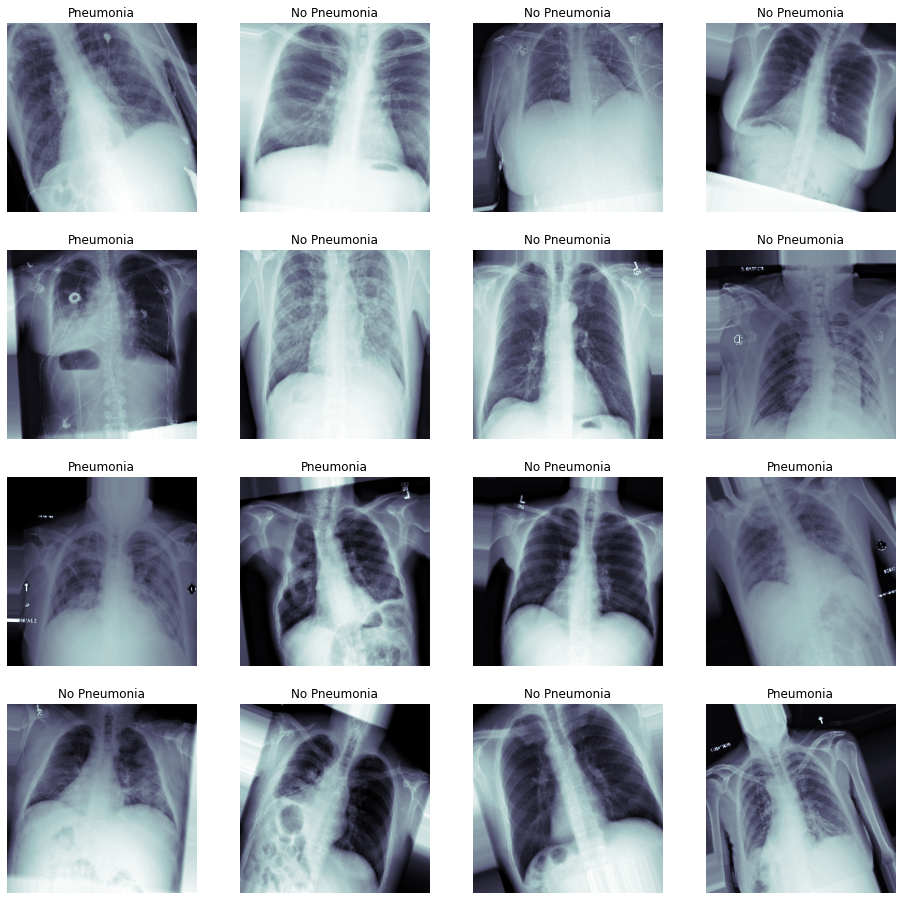

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')
plt.show()

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
def load_pretrained_model(**vargs):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Freeze most of the layers 
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    # Print out a list of the layers and whether or not they are trainable
    print('VGG16 layers:')
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
        
    return vgg_model

In [13]:
def build_my_model(**vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    
    vgg_model = load_pretrained_model()
    
    my_model = Sequential()
    my_model.add(vgg_model)
    # Flatten the output of VGG16's convolutional layer
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    # Add Dense layers and Dropout layers
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.3))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.3))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.3))
    my_model.add(Dense(128, activation='relu'))
    my_model.add(Dropout(0.3))
    my_model.add(Dense(64, activation='relu'))
    my_model.add(Dropout(0.3))
    # Last layer should have sigmoid activation
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [14]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

In [15]:
my_model = build_my_model()
my_model.summary()

553467904/553467096 [==============================] - 6s 0us/step
VGG16 layers:
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)     

### Start training! 

In [16]:
## train your model
optimizer = Adam(lr=1e-4)
my_model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['binary_accuracy'])

history = my_model.fit_generator(train_gen, 
                                 validation_data = (valX, valY), 
                                 epochs = 30, 
                                 callbacks = callbacks_list)

Epoch 1/30
36/36 [==============================] - 79s 2s/step - loss: 0.7615 - binary_accuracy: 0.4978 - val_loss: 0.7084 - val_binary_accuracy: 0.3524

Epoch 00001: val_loss improved from inf to 0.70836, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
36/36 [==============================] - 57s 2s/step - loss: 0.7251 - binary_accuracy: 0.5109 - val_loss: 0.6642 - val_binary_accuracy: 0.7510

Epoch 00002: val_loss improved from 0.70836 to 0.66417, saving model to xray_class_my_model.best.hdf5
Epoch 3/30
36/36 [==============================] - 59s 2s/step - loss: 0.7094 - binary_accuracy: 0.5149 - val_loss: 0.6813 - val_binary_accuracy: 0.6392

Epoch 00003: val_loss did not improve from 0.66417
Epoch 4/30
36/36 [==============================] - 59s 2s/step - loss: 0.7006 - binary_accuracy: 0.5162 - val_loss: 0.6829 - val_binary_accuracy: 0.6021

Epoch 00004: val_loss did not improve from 0.66417
Epoch 5/30
36/36 [==============================] - 59s 2s/step - loss: 0.6920

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [17]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, verbose = True)

1430/1430 [==============================] - 16s 11ms/step


In [18]:
def plot_auc(y_true, y_prediction):
    fig_auc, auc_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(y_true, y_prediction, pos_label = 1)
    auc_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    auc_ax.legend(loc='lower right')
    auc_ax.set_xlabel('False Positive Rate')
    auc_ax.set_ylabel('True Positive Rate')
    auc_ax.set_title('AUC ROC Curve')


## what other performance statistics do you want to include here besides AUC? 

def plot_pr(y_true, y_prediction):
    fig_pr, pr_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(y_true, y_prediction)
    pr_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(y_true,y_prediction)))
    pr_ax.legend()
    pr_ax.set_xlabel('Recall')
    pr_ax.set_ylabel('Precision')
    pr_ax.set_title('Precision and Recall')
    
#Also consider plotting the history of your model training:

def plot_history(history):
    hist = plt.figure()
    hist.set_figwidth(10)
    hist.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()

    hist.add_subplot(1, 2, 2)
    plt.plot(history.history['val_binary_accuracy'], label='val accuracy')
    plt.plot(history.history['binary_accuracy'], label='train accuracy')
    plt.legend()
    hist.suptitle('Training and Validation History')

    plt.show()

def plot_all_forms(y_true, y_prediction, history):
    plot_history(history)
    plot_auc(y_true, y_prediction)
    plot_pr(y_true, y_prediction)
    return


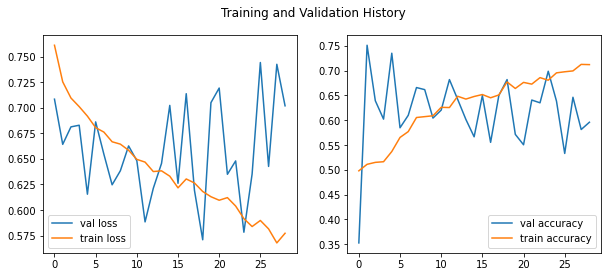

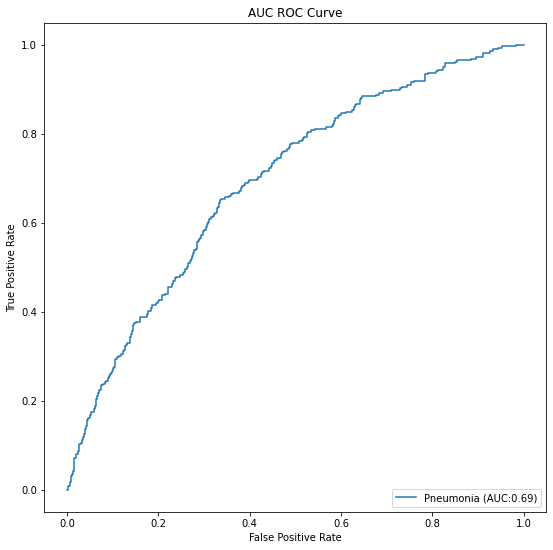

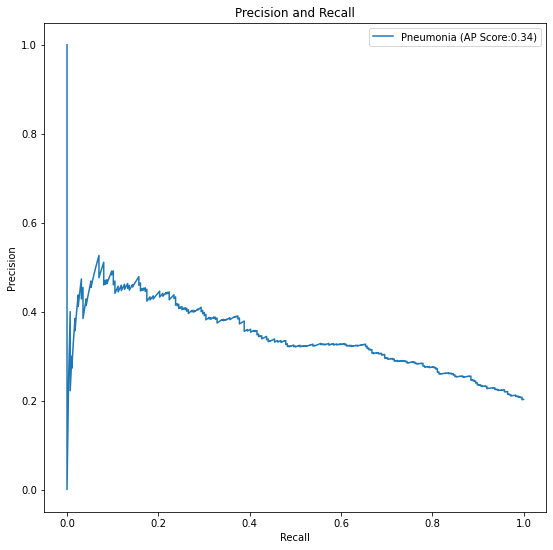

In [19]:
# Plot figures
plot_all_forms(valY, pred_Y, history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [20]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
print(len(valY))
print(len(pred_Y))
print(len(precision))
print(len(recall))
print(len(thresholds))

1430
1430
1412
1412
1411


In [21]:
# calc F1 scores
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))

Precision: 0.3269230769230769
Recall: 0.6538461538461539
Threshold: 0.42863157
F1 Score: 0.4358974358974359


I had to add the if statement to my calc_f1 function. without it, the last two numbers were NaN and threw off the rest of the values (everything was 0 or NaN). when I zeroed them out the results printed above made sense with graph below which was the same even when the above print outs were nonsense

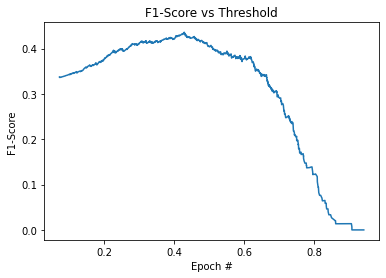

In [22]:
# plot the f1 scores
plt.figure()
plt.plot(thresholds, f1score)
plt.title("F1-Score vs Threshold")
plt.xlabel("Epoch #")
plt.ylabel("F1-Score")
plt.show()

In [23]:
#test out threshold from above
YOUR_THRESHOLD = thresholds[idx]

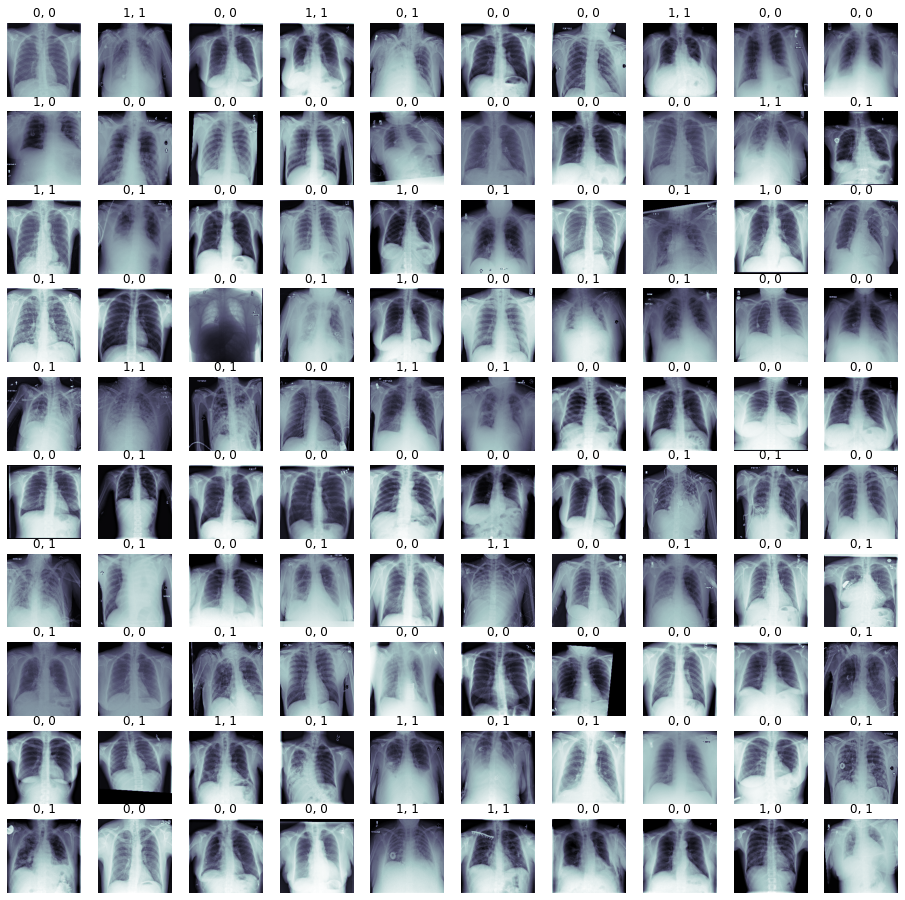

In [24]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [25]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

## Summary of Findings
The final threshold, 0.42 was chosen as it was the threshold for the maximum F1 score identified. The max F1 score was 0.43 and associated with this was a precision of 0.32 and a recall of 0.65. Though the recall is high and the precision low, F1 score is low as it is a balance of the two and heavily effected by precision being so low. This is ok in our circumstance as these values mean the algorithm is more likely to give false positives then false negatives, which is acceptable as this algorithm would only be used as an assistive tool to radiologist. We would want the algorithm to flag more cases as potential pneumonia (even if they're not -- false positive) for the radiologist to take a closer look at so there is less chance of the radiologist missing one. 

Training min Age:  2
Training max Age:  90
Val Min Age:  2
Val Max Age:  90
There are 932 ( 40.73426573426573 %)females and 1356 ( 59.265734265734274 %) males in the training dataset
Of the patients in the training set with pneumonia, 41.17132867132867% are female and 58.828671328671334% are male
There are 623 ( 43.56643356643357 %)females and 807 ( 56.433566433566426 %) males in the validation dataset


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/li

Of the patients in the validation set with pneumonia, 42.65734265734265% are female and 57.34265734265735% are male


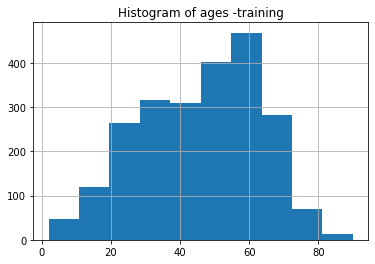

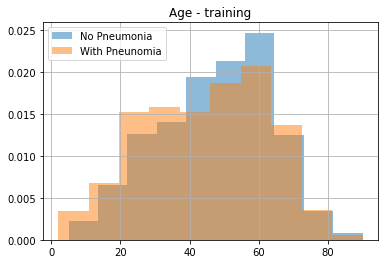

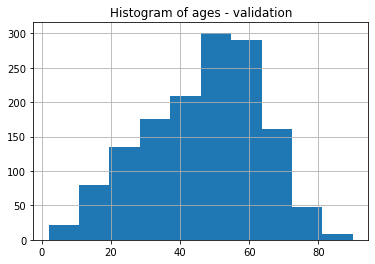

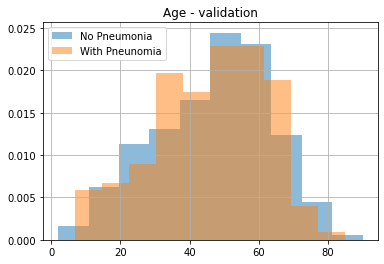

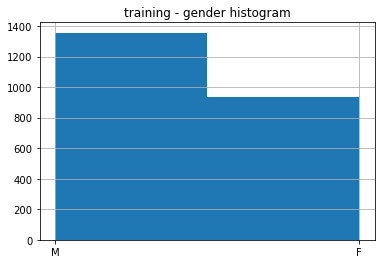

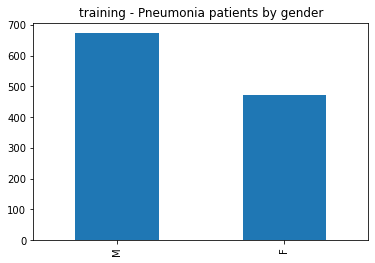

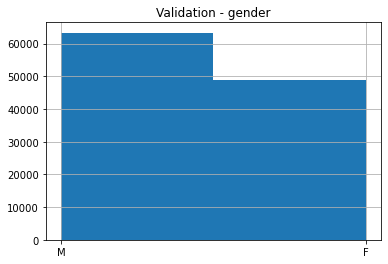

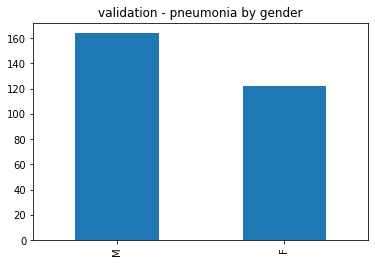

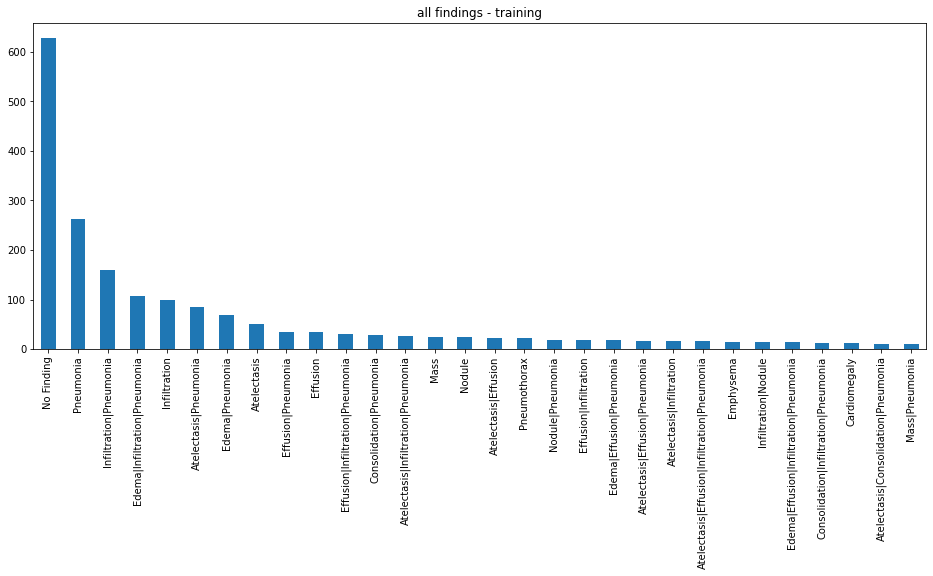

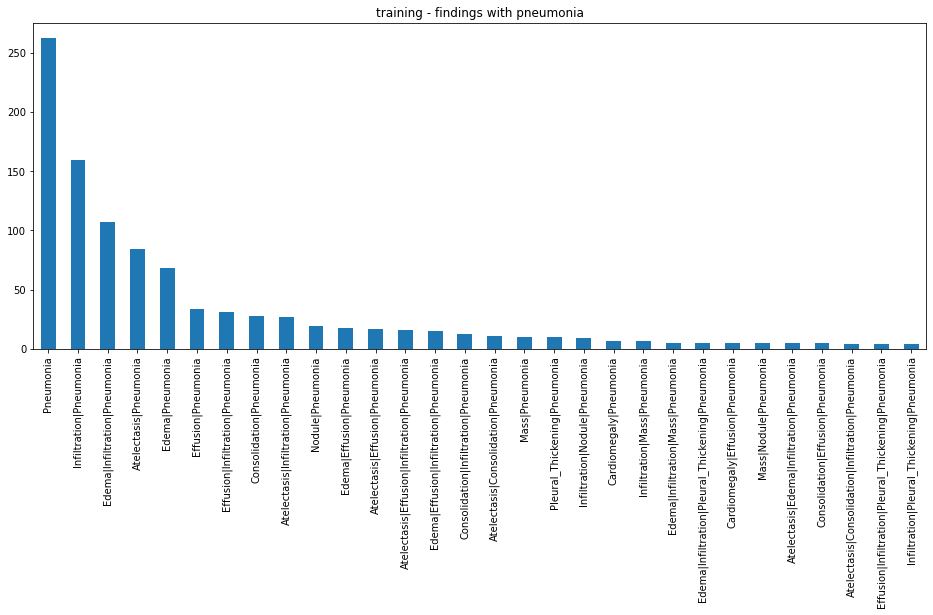

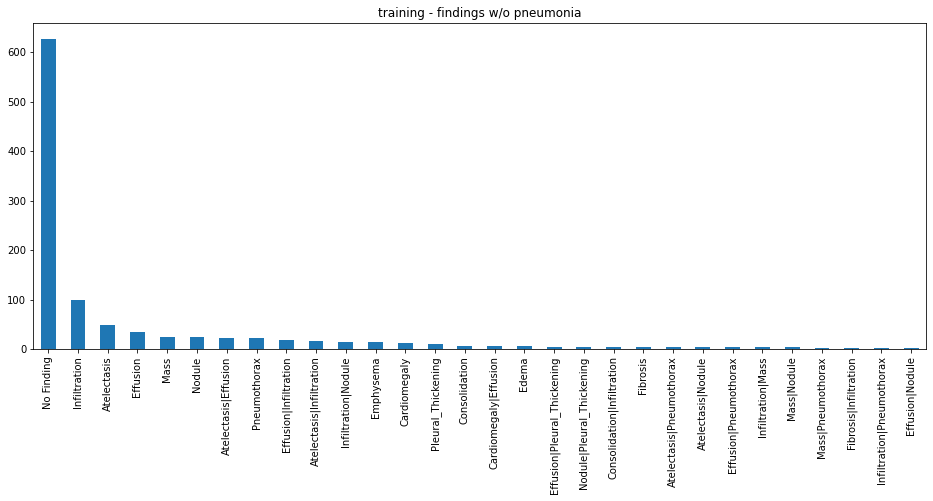

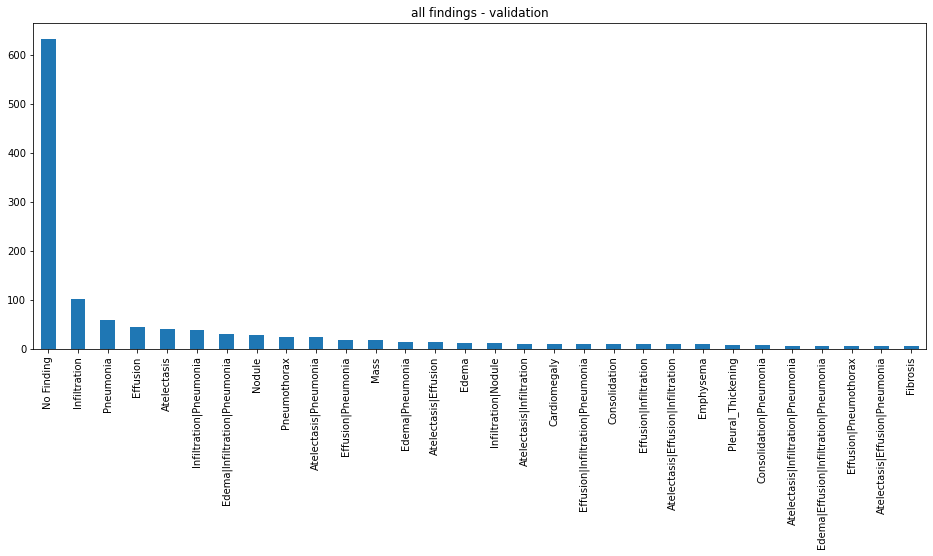

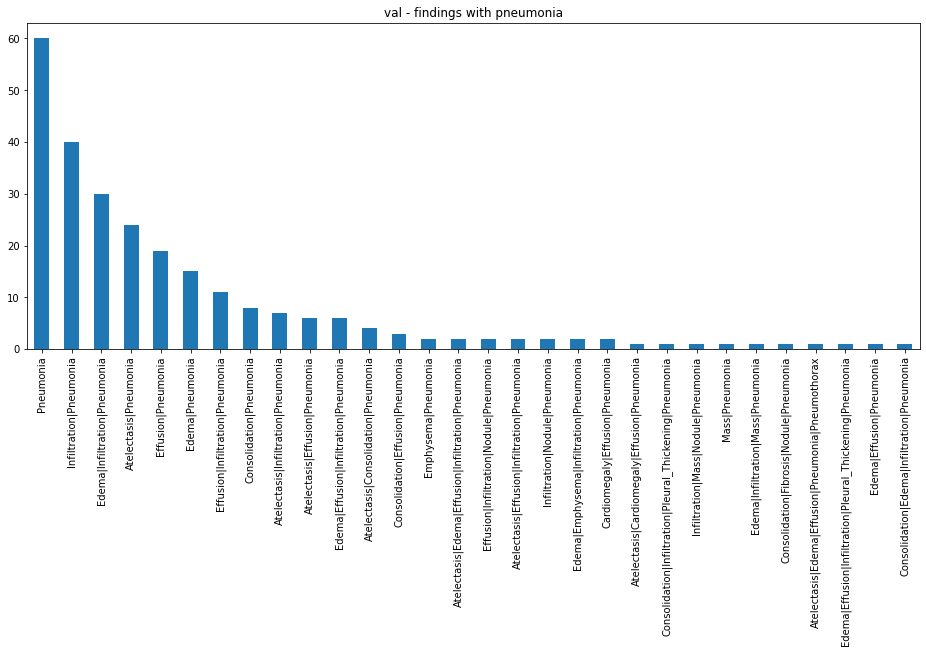

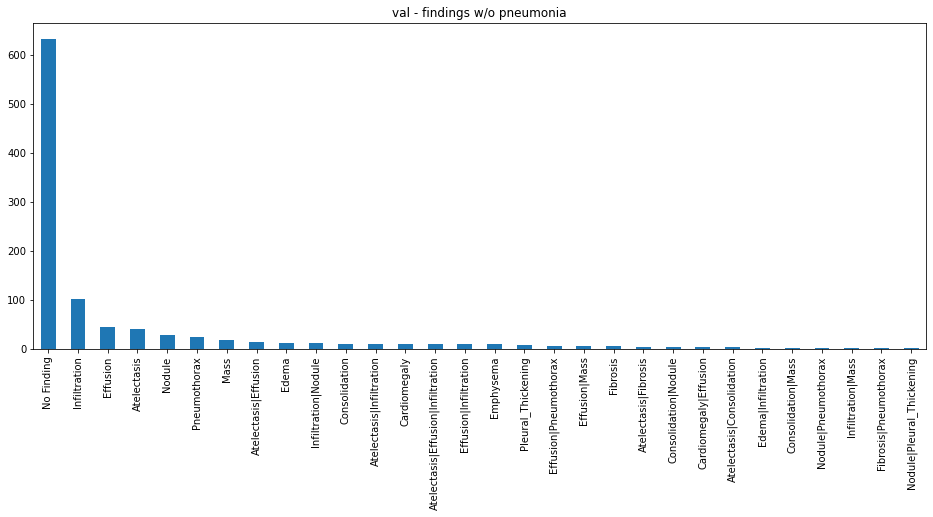

In [26]:
## Follow up information for FDA Submission
# age prevalance in testing/validation sets 
plt.figure()
plt.title('Histogram of ages -training')
training_df['Patient Age'].hist()
print('Training min Age: ',training_df['Patient Age'].min())
print('Training max Age: ',training_df['Patient Age'].max())
plt.figure()
training_df.groupby(['Pneumonia'])['Patient Age'].hist(density=True, alpha=0.5)
plt.legend(['No Pneumonia', 'With Pneunomia'])
plt.title('Age - training')
plt.figure()
plt.title('Histogram of ages - validation')
validation_df['Patient Age'].hist()
print('Val Min Age: ',validation_df['Patient Age'].min())
print('Val Max Age: ',validation_df['Patient Age'].max())
plt.figure()
validation_df.groupby(['Pneumonia'])['Patient Age'].hist(density=True, alpha=0.5)
plt.legend(['No Pneumonia', 'With Pneunomia'])
plt.title('Age - validation')

# gender
#training 
males = len(training_df[training_df['Patient Gender'] == 'M'])
females = len(training_df[training_df['Patient Gender'] == 'F'])
perc_f = 100*(females/(males+females))
perc_m = 100*(males/(males+females))
print('There are',females,'(',perc_f,'%)females and',males,'(',perc_m,'%) males in the training dataset')
plt.figure()
plt.title('training - gender histogram')
training_df['Patient Gender'].hist(bins=2)
pp_male = len(training_df[training_df['Pneumonia']==1][training_df['Patient Gender']=='M'])
pn_male = len(training_df[training_df['Pneumonia']==0][training_df['Patient Gender']=='M'])
pp_fmale = len(training_df[training_df['Pneumonia']==1][training_df['Patient Gender']=='F'])
pn_fmale = len(training_df[training_df['Pneumonia']==0][training_df['Patient Gender']=='F'])
f_perc2 = 100*(pp_fmale/(pp_fmale+pp_male))
m_perc2 = 100*(pp_male/(pp_fmale+pp_male))
print(f'Of the patients in the training set with pneumonia, {f_perc2}% are female and {m_perc2}% are male')
plt.figure()
plt.title('training - Pneumonia patients by gender')
training_df[training_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')
#validation
males = len(validation_df[validation_df['Patient Gender'] == 'M'])
females = len(validation_df[validation_df['Patient Gender'] == 'F'])
perc_f = 100*(females/(males+females))
perc_m = 100*(males/(males+females))
print('There are',females,'(',perc_f,'%)females and',males,'(',perc_m,'%) males in the validation dataset')
plt.figure()
plt.title('Validation - gender')
all_xray_df['Patient Gender'].hist(bins=2)
pp_male = len(validation_df[validation_df['Pneumonia']==1][validation_df['Patient Gender']=='M'])
pn_male = len(validation_df[validation_df['Pneumonia']==0][validation_df['Patient Gender']=='M'])
pp_fmale = len(validation_df[validation_df['Pneumonia']==1][validation_df['Patient Gender']=='F'])
pn_fmale = len(validation_df[validation_df['Pneumonia']==0][validation_df['Patient Gender']=='F'])
f_perc2 = 100*(pp_fmale/(pp_fmale+pp_male))
m_perc2 = 100*(pp_male/(pp_fmale+pp_male))
print(f'Of the patients in the validation set with pneumonia, {f_perc2}% are female and {m_perc2}% are male')
plt.figure()
plt.title('validation - pneumonia by gender')
validation_df[validation_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')

# Disease prevelance
# training 
plt.figure(figsize=(16,6))
plt.title('all findings - training')
training_df['Finding Labels'].value_counts()[0:30].plot(kind='bar')
plt.figure(figsize=(16,6))
plt.title('training - findings with pneumonia')
training_df[training_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')
plt.figure(figsize=(16,6))
plt.title('training - findings w/o pneumonia')
training_df[training_df.Pneumonia==0]['Finding Labels'].value_counts()[0:30].plot(kind='bar')
# validation
plt.figure(figsize=(16,6))
plt.title('all findings - validation')
validation_df['Finding Labels'].value_counts()[0:30].plot(kind='bar')
plt.figure(figsize=(16,6))
plt.title('val - findings with pneumonia')
validation_df[validation_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')
plt.figure(figsize=(16,6))
plt.title('val - findings w/o pneumonia')
validation_df[validation_df.Pneumonia==0]['Finding Labels'].value_counts()[0:30].plot(kind='bar')
